## Data cleaning

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
from thefuzz import process

In [2]:
# Read the data
wdi_raw = pd.read_csv('../data/raw/wdi_data.csv')
wdi_raw.head()

,Country,series,Country.1,Series,YR1990,YR1991,YR1992,YR1993,YR1994,YR1995,...,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023,YR2024
0,ZWE,SP.POP.TOTL,Zimbabwe,"Population, total",10137281.0,10404816.0,10702700.0,10860288.0,10873148.0,10974599.0,...,14399013.0,14600294.0,14812482.0,15034452.0,15271368.0,15526888.0,15797210.0,16069056.0,16340822.0,16634373.0
1,ZMB,SP.POP.TOTL,Zambia,"Population, total",7786169.0,7981650.0,8176680.0,8373921.0,8576269.0,8785763.0,...,16399089.0,16914423.0,17441320.0,17973569.0,18513839.0,19059395.0,19603607.0,20152938.0,20723965.0,21314956.0
2,YEM,SP.POP.TOTL,"Yemen, Rep.","Population, total",13887862.0,14430201.0,14989494.0,15563914.0,16149147.0,16740058.0,...,31159379.0,32109010.0,33090921.0,34085182.0,35111408.0,36134863.0,37140230.0,38222876.0,39390799.0,40583164.0
3,PSE,SP.POP.TOTL,West Bank and Gaza,"Population, total",1978248.0,2068845.0,2163591.0,2262676.0,2366298.0,2474666.0,...,4270092.0,4367088.0,4454805.0,4569087.0,4685306.0,4803269.0,4922749.0,5043612.0,5165775.0,5289152.0
4,VIR,SP.POP.TOTL,Virgin Islands (U.S.),"Population, total",103963.0,104807.0,105712.0,106578.0,107318.0,107818.0,...,107712.0,107516.0,107281.0,107001.0,106669.0,106290.0,105870.0,105413.0,104917.0,104377.0


In [3]:
# Keep relevant columns and melt years into long format
wdi_raw = wdi_raw.drop(columns=['series'])  # drop redundant 'series' column

# Reshape the DataFrame from wide to long format
wdi_long = wdi_raw.melt(
    id_vars=['Country', 'Country.1', 'Series'],  # keep ISO3 ('Country') and full name ('Country.1')
    var_name='Year',
    value_name='Value'
)

# Clean Year column
wdi_long['Year'] = wdi_long['Year'].str.replace('YR', '').astype(int)

# Rename columns for clarity
wdi_long.rename(columns={
    'Country.1': 'Country_Name',  # full country name
    'Country': 'ISO3',            # ISO3 code
    'Series': 'Indicator'
}, inplace=True)

In [4]:
# Pivot to panel (ISO3 x Year) and keep full country name
wdi_panel = wdi_long.pivot_table(
    index=['ISO3', 'Country_Name', 'Year'],  # include ISO3 and full name
    columns='Indicator',
    values='Value'
).reset_index()

# Clean column names
wdi_panel.columns = wdi_panel.columns.astype(str).str.strip()  # remove whitespace

# Identify indicator columns
indicator_cols = [c for c in wdi_panel.columns if c not in ['ISO3', 'Country_Name', 'Year']]

In [5]:
# Check unique countries (country groups)
wdi_panel['Country_Name'].unique()

array(['Aruba', 'Africa Eastern and Southern', 'Afghanistan',
       'Africa Western and Central', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'American Samoa', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Channel Islands',
       'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark',
       'Dominican Republic', 'Algeria',
 

In [6]:
# Define aggregates and drop them / keep only countries
aggregates = sorted([
    'Africa Eastern and Southern',
    'Arab World',
    'Central Europe and the Baltics',
    'East Asia & Pacific',
    'East Asia & Pacific (IDA & IBRD countries)',
    'East Asia & Pacific (excluding high income)',
    'Europe & Central Asia',
    'Europe & Central Asia (IDA & IBRD countries)',
    'Europe & Central Asia (excluding high income)',
    'Euro area',
    'European Union',
    'Early-demographic dividend',
    'Heavily indebted poor countries (HIPC)',
    'High income',
    'IBRD only',
    'IDA & IBRD total',
    'IDA only',
    'IDA total',
    'Latin America & Caribbean',
    'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'Late-demographic dividend',
    'Least developed countries: UN classification',
    'Low & middle income',
    'Low income',
    'Lower middle income',
    'Middle East, North Africa, Afghanistan & Pakistan',
    'Middle East, North Africa, Afghanistan & Pakistan (IDA & IBRD)',
    'Middle East, North Africa, Afghanistan & Pakistan (excluding high income)',
    'Middle income',
    'North America',
    'OECD members',
    'Other small states',
    'Post-demographic dividend',
    'Pre-demographic dividend',
    'Small states',
    'South Asia',
    'South Asia (IDA & IBRD)',
    'Sub-Saharan Africa',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Sub-Saharan Africa (excluding high income)',
    'Upper middle income',
    'World'
])

# Drop aggregates from the cleaned dataset
wdi_panel = wdi_panel.loc[~wdi_panel['Country_Name'].isin(aggregates)].copy()

In [7]:
wdi_panel['Country_Name'].unique()

array(['Aruba', 'Afghanistan', 'Africa Western and Central', 'Angola',
       'Albania', 'Andorra', 'United Arab Emirates', 'Argentina',
       'Armenia', 'American Samoa', 'Antigua and Barbuda', 'Australia',
       'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain',
       'Bahamas, The', 'Bosnia and Herzegovina', 'Belarus', 'Belize',
       'Bermuda', 'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam',
       'Bhutan', 'Botswana', 'Central African Republic', 'Canada',
       'Switzerland', 'Channel Islands', 'Chile', 'China',
       "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark',
       'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt, Arab Rep.',
       'Eritrea', 'Spain', 'Estonia', 'Ethiopia',
      

In [8]:
wdi_panel['ISO3'].unique()

array(['ABW', 'AFG', 'AFW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM',
       'ASM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA',
       'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL',
       'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHI',
       'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV',
       'CRI', 'CSS', 'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST',
       'ETH', 'FCS', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR',
       'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD',
       'GRL', 'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN',
       'IDB', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR',
       'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR',
       'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE',
       'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAF', 'MAR', 'MCO',
       'MDA', 'MDG',

## Merging with HDI data

In [9]:
# Step 1: Load HDR data
hdr = pd.read_excel('../data/raw/hdr-data.xlsx', usecols=['countryIsoCode','country','year','value'])

# Step 2: Rename columns to match WDI panel
hdr.rename(columns={
    'countryIsoCode': 'ISO3',   # ISO3 code
    'country': 'Country_Name',  # full country name
    'year': 'Year',
    'value': 'HDI'
}, inplace=True)
hdr['Year'] = hdr['Year'].astype(int)

# Step 3: Identify HDR countries not matching WDI
wdi_countries_iso = set(wdi_panel['ISO3'].unique())
hdr_countries_iso = set(hdr['ISO3'].unique())
mismatched_iso = hdr_countries_iso - wdi_countries_iso
print("Countries in HDR not matching WDI (by ISO3):", mismatched_iso)

# Step 4: Suggest closest WDI matches using fuzzy matching (on country names)
mapping_suggestions = {}
for c in hdr.loc[hdr['ISO3'].isin(mismatched_iso), 'Country_Name']:
    match = process.extractOne(c, wdi_panel['Country_Name'].unique())
    mapping_suggestions[c] = match[0]

print("\nSuggested mapping (HDR -> WDI names):")
for k, v in mapping_suggestions.items():
    print(f"{k} -> {v}")

Countries in HDR not matching WDI (by ISO3): set()

Suggested mapping (HDR -> WDI names):


In [10]:
# Step 5: Merge HDR HDI into cleaned WDI dataset
wdi_hdr = wdi_panel.merge(
    hdr,
    on=['ISO3', 'Year'],   # merge by ISO3 and Year
    how='left'
)

# Optional: if 'Country_Name' exists on both sides, rename to clean
if 'Country_Name_x' in wdi_hdr.columns:
    wdi_hdr.rename(columns={'Country_Name_x': 'Country_Name'}, inplace=True)

# Drop Country_Name_y if exists
if 'Country_Name_y' in wdi_hdr.columns:
    wdi_hdr.drop(columns=['Country_Name_y'], inplace=True)

# Step 6: Check result
print(wdi_hdr[['ISO3', 'Country_Name', 'Year', 'HDI']].head(10))
missing_hdi = wdi_hdr['HDI'].isna().sum()
print(f"Missing HDI values after merge: {missing_hdi}")

  ISO3 Country_Name  Year  HDI
0  ABW        Aruba  1990  NaN
1  ABW        Aruba  1991  NaN
2  ABW        Aruba  1992  NaN
3  ABW        Aruba  1993  NaN
4  ABW        Aruba  1994  NaN
5  ABW        Aruba  1995  NaN
6  ABW        Aruba  1996  NaN
7  ABW        Aruba  1997  NaN
8  ABW        Aruba  1998  NaN
9  ABW        Aruba  1999  NaN
Missing HDI values after merge: 1830


In [11]:
# Drop countries HDI is missing for all years
wdi_hdr = wdi_hdr[wdi_hdr.groupby('ISO3')['HDI'].transform('count') > 0]

In [12]:
# Step 6: Check result
print(wdi_hdr[['ISO3', 'Country_Name', 'Year', 'HDI']].head(10))
missing_hdi = wdi_hdr['HDI'].isna().sum()
print(f"Missing HDI values after merge: {missing_hdi}")

   ISO3 Country_Name  Year    HDI
35  AFG  Afghanistan  1990  0.285
36  AFG  Afghanistan  1991  0.291
37  AFG  Afghanistan  1992  0.301
38  AFG  Afghanistan  1993  0.311
39  AFG  Afghanistan  1994  0.305
40  AFG  Afghanistan  1995  0.329
41  AFG  Afghanistan  1996  0.334
42  AFG  Afghanistan  1997  0.338
43  AFG  Afghanistan  1998  0.338
44  AFG  Afghanistan  1999  0.347
Missing HDI values after merge: 815


In [13]:
# Check shape and columns
print(wdi_hdr.shape)
print(wdi_hdr.columns)

# Quick overview of missing values
missing_summary = wdi_hdr.isna().sum().sort_values(ascending=False)
print(missing_summary)

(6755, 18)
Index(['ISO3', 'Country_Name', 'Year',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Exports of goods and services (% of GDP)',
       'Fertility rate, total (births per woman)', 'GDP growth (annual %)',
       'GDP per capita (constant 2015 US$)',
       'Imports of goods and services (% of GDP)',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Mortality rate, under-5 (per 1,000 live births)', 'Net migration',
       'Population density (people per sq. km of land area)',
       'Population, total',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)',
       'Urban population growth (annual %)', 'HDI'],
      dtype='object')
Imports of goods and services (% of GDP)                               1107
Exports of goods and services (% of GDP)                               1107
HDI                                                                     815
Un

/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_53756/1870073499.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_year = wdi_hdr.groupby('Year').apply(lambda x: x.isna().mean())


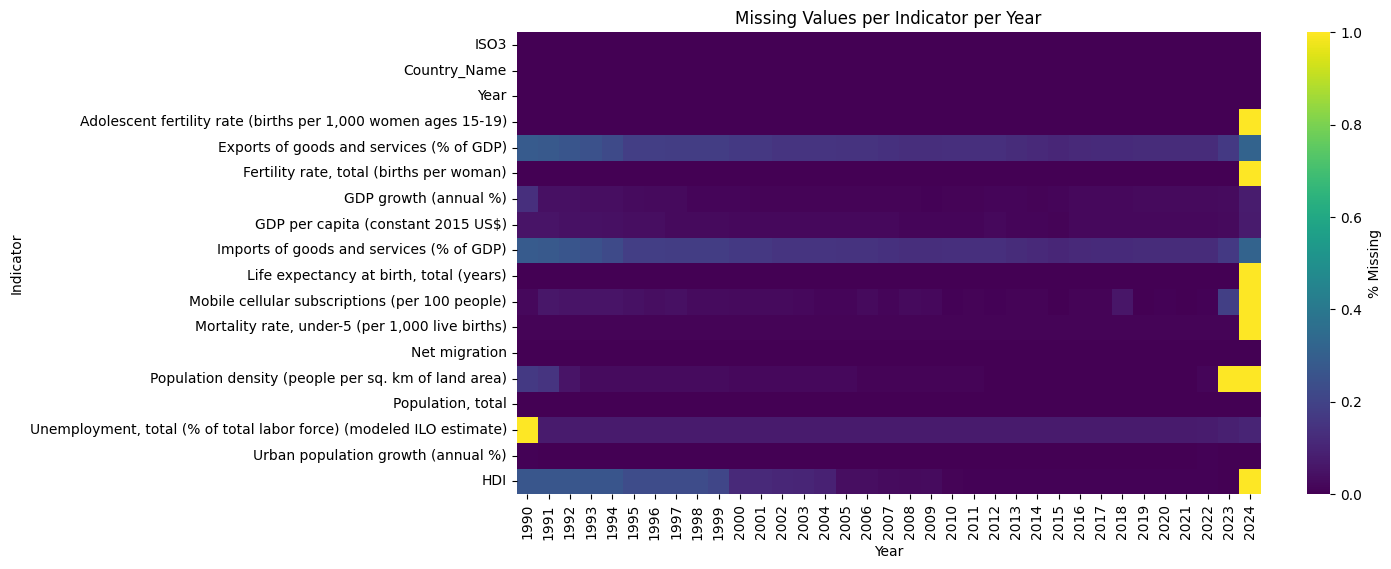

In [14]:
# Group by year and compute % missing
missing_by_year = wdi_hdr.groupby('Year').apply(lambda x: x.isna().mean())
plt.figure(figsize=(12,6))
sns.heatmap(missing_by_year.T, cmap='viridis', cbar_kws={'label':'% Missing'})
plt.xlabel('Year')
plt.ylabel('Indicator')
plt.title('Missing Values per Indicator per Year')
plt.show()

In [15]:
# Drop 2024 entirely
wdi_hdr = wdi_hdr[wdi_hdr['Year'] < 2024]

In [16]:
# List of all indicators in dataset (excluding ID columns)
indicators = [
    'Adolescent fertility rate (births per 1,000 women ages 15-19)',
    'Exports of goods and services (% of GDP)',
    'Fertility rate, total (births per woman)',
    'GDP growth (annual %)',
    'GDP per capita (constant 2015 US$)',
    'Imports of goods and services (% of GDP)',
    'Life expectancy at birth, total (years)',
    'Mobile cellular subscriptions (per 100 people)',
    'Mortality rate, under-5 (per 1,000 live births)',
    'Net migration',
    'Population density (people per sq. km of land area)',
    'Population, total',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Urban population growth (annual %)',
    'HDI'
]

# Check countries with no data for each indicator (drop countries missing any indicator entirely)
countries_to_drop = set()

for col in indicators:
    no_data_countries = wdi_hdr.groupby("Country_Name")[col].apply(lambda x: x.isna().all())
    missing_countries = no_data_countries[no_data_countries].index.tolist()
    print(f"{col}: {len(missing_countries)} countries with no data at all")
    print(missing_countries)
    countries_to_drop.update(missing_countries)

print(f"\nTotal countries to drop (missing any indicator): {len(countries_to_drop)}")
print(countries_to_drop)

# Drop these countries from dataset
wdi_hdr = wdi_hdr[~wdi_hdr['Country_Name'].isin(countries_to_drop)].reset_index(drop=True)

print(f"\nShape after dropping countries: {wdi_hdr.shape}")

Adolescent fertility rate (births per 1,000 women ages 15-19): 0 countries with no data at all
[]
Exports of goods and services (% of GDP): 15 countries with no data at all
['Andorra', 'Barbados', 'Dominica', 'Grenada', 'Liberia', 'Liechtenstein', 'Malawi', 'Myanmar', 'Nigeria', 'Sao Tome and Principe', 'St. Kitts and Nevis', 'St. Lucia', 'St. Vincent and the Grenadines', 'Trinidad and Tobago', 'Tuvalu']
Fertility rate, total (births per woman): 0 countries with no data at all
[]
GDP growth (annual %): 0 countries with no data at all
[]
GDP per capita (constant 2015 US$): 1 countries with no data at all
['Venezuela, RB']
Imports of goods and services (% of GDP): 15 countries with no data at all
['Andorra', 'Barbados', 'Dominica', 'Grenada', 'Liberia', 'Liechtenstein', 'Malawi', 'Myanmar', 'Nigeria', 'Sao Tome and Principe', 'St. Kitts and Nevis', 'St. Lucia', 'St. Vincent and the Grenadines', 'Trinidad and Tobago', 'Tuvalu']
Life expectancy at birth, total (years): 0 countries with no 

# Data Imputation

In [17]:
# Impute missing values, but check the range of existing values first

# Get descriptive statistics for all numeric columns
wdi_hdr.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,5712.0,2.006500e+03,9.811567e+00,1.990000e+03,1.998000e+03,2.006500e+03,2.015000e+03,2.023000e+03
"Adolescent fertility rate (births per 1,000 women ages 15-19)",5712.0,5.877308e+01,4.692163e+01,5.370000e-01,1.851125e+01,4.773500e+01,8.862700e+01,2.122510e+02
Exports of goods and services (% of GDP),5280.0,3.800728e+01,2.642736e+01,5.376759e-03,2.104050e+01,3.224409e+01,4.773913e+01,2.289938e+02
"Fertility rate, total (births per woman)",5712.0,3.166828e+00,1.688877e+00,7.210000e-01,1.740000e+00,2.665000e+00,4.384500e+00,8.606000e+00
GDP growth (annual %),5593.0,3.450394e+00,6.673244e+00,-6.404711e+01,1.399916e+00,3.745681e+00,6.001342e+00,1.499730e+02
GDP per capita (constant 2015 US$),5623.0,1.176864e+04,1.728243e+04,1.886583e+02,1.410175e+03,4.058816e+03,1.292359e+04,1.124179e+05
Imports of goods and services (% of GDP),5280.0,4.290067e+01,2.378296e+01,1.562247e-02,2.694456e+01,3.699934e+01,5.392895e+01,2.083329e+02
"Life expectancy at birth, total (years)",5712.0,6.862008e+01,9.620732e+00,1.215800e+01,6.265825e+01,7.056450e+01,7.586890e+01,8.456000e+01
Mobile cellular subscriptions (per 100 people),5601.0,5.686259e+01,5.390258e+01,0.000000e+00,1.376149e+00,4.701520e+01,1.057940e+02,2.204120e+02
"Mortality rate, under-5 (per 1,000 live births)",5712.0,4.645861e+01,5.253498e+01,2.100000e+00,9.400000e+00,2.445000e+01,6.622500e+01,4.789000e+02


In [18]:
# 0️⃣ Sort by Country and Year
wdi_hdr = wdi_hdr.sort_values(['Country_Name', 'Year']).reset_index(drop=True)

# 1️⃣ Define variable groups
time_series_vars = [
    'GDP growth (annual %)',
    'GDP per capita (constant 2015 US$)',
    'Urban population growth (annual %)'
]

bounded_vars = [
    'Adolescent fertility rate (births per 1,000 women ages 15-19)',
    'Fertility rate, total (births per woman)',
    'Life expectancy at birth, total (years)',
    'Mobile cellular subscriptions (per 100 people)',
    'Mortality rate, under-5 (per 1,000 live births)',
    'HDI'
]

trade_vars = [
    'Exports of goods and services (% of GDP)',
    'Imports of goods and services (% of GDP)'
]

net_migration_var = ['Net migration']

population_density_var = ['Population density (people per sq. km of land area)']

# 2️⃣ Impute time-series variables with linear interpolation
for col in time_series_vars:
    wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.interpolate(method='linear'))

# 3️⃣ Impute bounded variables: linear interpolation + median, then clip negatives
for col in bounded_vars:
    wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.interpolate(method='linear'))
    wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.fillna(x.median()))
    wdi_hdr[col] = wdi_hdr[col].clip(lower=0)

# 4️⃣ Impute trade variables: linear interpolation + median
for col in trade_vars:
    wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.interpolate(method='linear'))
    wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.fillna(x.median()))
    wdi_hdr[col] = wdi_hdr[col].clip(lower=0)

# 5️⃣ Impute net migration: linear interpolation + median
for col in net_migration_var:
    wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.interpolate(method='linear'))
    wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.fillna(x.median()))

# 6️⃣ Impute population density: linear interpolation + median
for col in population_density_var:
    wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.interpolate(method='linear'))
    wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.fillna(x.median()))
    wdi_hdr[col] = wdi_hdr[col].clip(lower=0)

# ✅ Optional: check remaining missing values
print(wdi_hdr.isna().sum())

ISO3                                                                     0
Country_Name                                                             0
Year                                                                     0
Adolescent fertility rate (births per 1,000 women ages 15-19)            0
Exports of goods and services (% of GDP)                                 0
Fertility rate, total (births per woman)                                 0
GDP growth (annual %)                                                   94
GDP per capita (constant 2015 US$)                                      69
Imports of goods and services (% of GDP)                                 0
Life expectancy at birth, total (years)                                  0
Mobile cellular subscriptions (per 100 people)                           0
Mortality rate, under-5 (per 1,000 live births)                          0
Net migration                                                            0
Population density (peopl

In [19]:
# Columns with remaining missing values
remaining_missing = {
    'GDP growth (annual %)': 'median',
    'GDP per capita (constant 2015 US$)': 'median',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'median',
    'Urban population growth (annual %)': 'median'
}

# Impute remaining missing values
for col, method in remaining_missing.items():
    if method == 'median':
        wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.fillna(x.median()))
    elif method == 'mean':
        wdi_hdr[col] = wdi_hdr.groupby('Country_Name')[col].transform(lambda x: x.fillna(x.mean()))
    else:
        raise ValueError(f"Unknown imputation method: {method}")

# Verify missing values
print(wdi_hdr.isna().sum())

ISO3                                                                   0
Country_Name                                                           0
Year                                                                   0
Adolescent fertility rate (births per 1,000 women ages 15-19)          0
Exports of goods and services (% of GDP)                               0
Fertility rate, total (births per woman)                               0
GDP growth (annual %)                                                  0
GDP per capita (constant 2015 US$)                                     0
Imports of goods and services (% of GDP)                               0
Life expectancy at birth, total (years)                                0
Mobile cellular subscriptions (per 100 people)                         0
Mortality rate, under-5 (per 1,000 live births)                        0
Net migration                                                          0
Population density (people per sq. km of land area)

In [20]:
# Save cleaned dataset
wdi_hdr.to_csv("..//data/processed/wdi_hdr.csv", index=False)